In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#scikit-learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
compas_two_year = pd.read_csv('data/compas-scores-two-years.csv')
compas_two_year_violent = pd.read_csv('data/compas-scores-two-years-violent.csv')

# Analysis on Potential Cause of Bias

According to Northpointe, the developer of COMPAS, information about sex, age, and race is not used when determining a COMPAS score. However, these demographic characteristics are correlated with recidivism as well as the criteria used in determining COMPAS scores.

We formulate the causal chain as follows: demographic characteristics affect recidivism (i.e. some sex, age category(ies), and race(s) are more likely to commit recidivism than others, for reasons that are out of scope for this analysis); at the same time, they affect the outcome of the criteria (e.g. vocation education) used in determining COMPAS scores, which are used in predicting recidivism.

We compare the coefficient of determination ($R^2$ score) of demographic characteristics regressed against two-year recidivism:
1. with no regard to COMPAS score TO
2. that (the coefficient of determination) conditioned on COMPAS score,

for all demographic characteristics and each of them separately.

If the COMPAS scores are unbiased, the $R^2$ scores for 1 and 2 should be the same.

## All

Unconditioned R-Squared: 0.3739879810215827


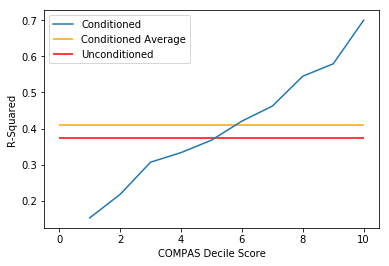

In [5]:
X_sar = compas_two_year.loc[:, ['sex', 'age_cat', 'race']]
X_sar = pd.get_dummies(X_sar)
X_sar = X_sar.drop(['sex_Male', 'age_cat_25 - 45', 'race_Caucasian'], axis=1)
y_sar = compas_two_year['two_year_recid']
model_sar = sm.OLS(y_sar, X_sar).fit()
print('Unconditioned R-Squared:', model_sar.rsquared)

rsquareds = []
for i in range(1, 11):
    X_sar_i = compas_two_year.loc[compas_two_year['decile_score.1'] == i, ['sex', 'age_cat', 'race']]
    X_sar_i = pd.get_dummies(X_sar_i)
    X_sar_i = X_sar_i.drop(['sex_Male', 'age_cat_25 - 45', 'race_Caucasian'], axis=1)
    y_sar_i = compas_two_year.loc[compas_two_year['decile_score.1'] == i, 'two_year_recid']
    model_sar_i = sm.OLS(y_sar_i, X_sar_i).fit()
    rsquareds.append(model_sar_i.rsquared)

plt.plot(range(1, 11), rsquareds, label='Conditioned')
plt.hlines(np.mean(rsquareds), 0, 10, color='orange', label='Conditioned Average')
plt.hlines(model_sar.rsquared, 0, 10, color='red', label='Unconditioned')
plt.xlabel('COMPAS Decile Score')
plt.ylabel('R-Squared')
plt.legend();

As we can see, the average $R^2$ score for models conditioned on COMPAS score (orange line) is close to the unconditioned one (red line). This implies that on average, the COMPAS score is not systematically associated with demographic characteristics in general.

However, the conditioned $R^2$ scores (blue line) are positively correlated with COMPAS scores. The higher the COMPAS score is, the greater the association between demographic characteristics and recidivism.

## Sex

Unconditioned R-Squared: 0.054684910846290236


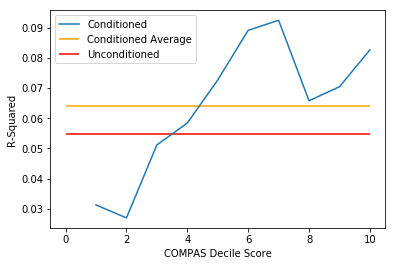

In [6]:
X_s = compas_two_year.loc[:, ['sex']]
X_s = pd.get_dummies(X_s)
X_s = X_s.drop(['sex_Male'], axis=1)
y_s = compas_two_year['two_year_recid']
model_s = sm.OLS(y_s, X_s).fit()
print('Unconditioned R-Squared:', model_s.rsquared)

rsquareds = []
for i in range(1, 11):
    X_s_i = compas_two_year.loc[compas_two_year['decile_score.1'] == i, ['sex']]
    X_s_i = pd.get_dummies(X_s_i)
    X_s_i = X_s_i.drop(['sex_Male'], axis=1)
    y_s_i = compas_two_year.loc[compas_two_year['decile_score.1'] == i, 'two_year_recid']
    model_s_i = sm.OLS(y_s_i, X_s_i).fit()
    rsquareds.append(model_s_i.rsquared)

plt.plot(range(1, 11), rsquareds, label='Conditioned')
plt.hlines(np.mean(rsquareds), 0, 10, color='orange', label='Conditioned Average')
plt.hlines(model_s.rsquared, 0, 10, color='red', label='Unconditioned')
plt.xlabel('COMPAS Decile Score')
plt.ylabel('R-Squared')
plt.legend();

Note the ticks for the y-axis. The actual association between sex and recidivism is very small, so is the association as a result of COMPAS.

In [7]:
pd.pivot_table(data=compas_two_year, values=['two_year_recid', 'decile_score.1'], columns='sex', aggfunc=np.mean)

sex,Female,Male
decile_score.1,4.172043,4.590479
two_year_recid,0.356989,0.473105


## Age

Unconditioned R-Squared: 0.19858133737677053


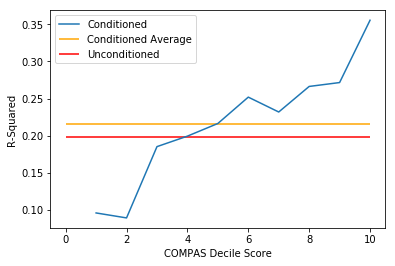

In [8]:
X_a = compas_two_year.loc[:, ['age_cat']]
X_a = pd.get_dummies(X_a)
X_a = X_a.drop(['age_cat_25 - 45'], axis=1)
y_a = compas_two_year['two_year_recid']
model_a = sm.OLS(y_a, X_a).fit()
print('Unconditioned R-Squared:', model_a.rsquared)

rsquareds = []
for i in range(1, 11):
    X_a_i = compas_two_year.loc[compas_two_year['decile_score.1'] == i, ['age_cat']]
    X_a_i = pd.get_dummies(X_a_i)
    X_a_i = X_a_i.drop(['age_cat_25 - 45'], axis=1)
    y_a_i = compas_two_year.loc[compas_two_year['decile_score.1'] == i, 'two_year_recid']
    model_a_i = sm.OLS(y_a_i, X_a_i).fit()
    rsquareds.append(model_a_i.rsquared)

plt.plot(range(1, 11), rsquareds, label='Conditioned')
plt.hlines(np.mean(rsquareds), 0, 10, color='orange', label='Conditioned Average')
plt.hlines(model_a.rsquared, 0, 10, color='red', label='Unconditioned')
plt.xlabel('COMPAS Decile Score')
plt.ylabel('R-Squared')
plt.legend();

In [9]:
pd.pivot_table(data=compas_two_year, values=['two_year_recid', 'decile_score.1'], columns='age_cat', aggfunc=np.mean)

age_cat,25 - 45,Greater than 45,Less than 25
decile_score.1,4.599659,2.917513,5.908437
two_year_recid,0.459723,0.315990,0.565075


## Race

Unconditioned R-Squared: 0.34366758416932275


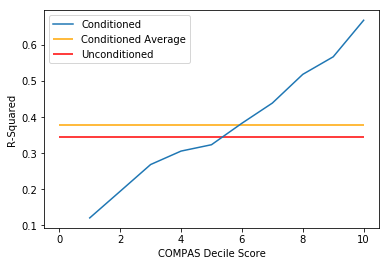

In [10]:
X_r = compas_two_year.loc[:, ['race']]
X_r = pd.get_dummies(X_r)
X_r = X_r.drop(['race_Caucasian'], axis=1)
y_r = compas_two_year['two_year_recid']
model_r = sm.OLS(y_r, X_r).fit()
print('Unconditioned R-Squared:', model_r.rsquared)

rsquareds = []
for i in range(1, 11):
    X_r_i = compas_two_year.loc[compas_two_year['decile_score.1'] == i, ['race']]
    X_r_i = pd.get_dummies(X_r_i)
    X_r_i = X_r_i.drop(['race_Caucasian'], axis=1)
    y_r_i = compas_two_year.loc[compas_two_year['decile_score.1'] == i, 'two_year_recid']
    model_r_i = sm.OLS(y_r_i, X_r_i).fit()
    rsquareds.append(model_r_i.rsquared)

plt.plot(range(1, 11), rsquareds, label='Conditioned')
plt.hlines(np.mean(rsquareds), 0, 10, color='orange', label='Conditioned Average')
plt.hlines(model_r.rsquared, 0, 10, color='red', label='Unconditioned')
plt.xlabel('COMPAS Decile Score')
plt.ylabel('R-Squared')
plt.legend();

In [11]:
pd.pivot_table(data=compas_two_year, values=['two_year_recid', 'decile_score.1'], columns='race', aggfunc=np.mean)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score.1,5.368777,2.93750,3.735126,3.463108,6.166667,2.949602
two_year_recid,0.514340,0.28125,0.393643,0.364207,0.555556,0.352785


The above observations can be associated with the heteroskedasticity of COMPAS scores.

In [12]:
def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -np.log(p)
    else:
        return -np.log(1 - p)

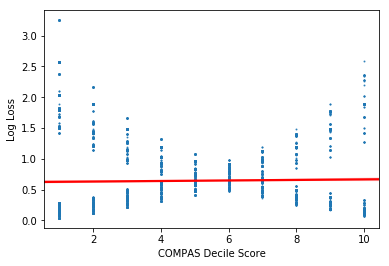

In [13]:
X_compas = compas_two_year.loc[:, ['sex', 'age_cat', 'race', 'decile_score.1']]
X_compas = pd.get_dummies(X_compas)
X_compas = X_compas.drop(['sex_Male', 'age_cat_25 - 45', 'race_Caucasian'], axis=1)
y_compas = compas_two_year['two_year_recid']
model_compas = sm.OLS(y_compas, X_compas).fit()

predictions_compas = model_compas.predict(X_compas)
# errors_compas = log_loss(y_compas, predictions_compas)
errors_compas = pd.concat([y_compas, predictions_compas], axis=1).apply(lambda x: logloss(x['two_year_recid'], x[0]), axis=1)

sns.regplot(X_compas['decile_score.1'], errors_compas, scatter_kws={'s': 1}, line_kws={'color': 'red'})
plt.xlabel('COMPAS Decile Score')
plt.ylabel('Log Loss');

# Suggested Improvements

In [14]:
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))
def sse(pred, actual):
    return sum((pred-actual)**2)
def AIC(train, pred, actual):
    return 2 * train.shape[1] - 2 * np.log(sse(pred, actual))
def BIC(train, pred, actual):
    return train.shape[0] * np.log(sse(pred,actual)/train.shape[0]) + train.shape[1] * np.log(train.shape[0])

In [15]:
sample =  compas_two_year_violent.loc[:,['sex','age_cat','race','two_year_recid']]
sample.head()

,sex,age_cat,race,two_year_recid
0,Male,Greater than 45,Other,0
1,Male,25 - 45,African-American,1
2,Male,Less than 25,African-American,0
3,Male,25 - 45,Other,0
4,Male,25 - 45,Other,0


### Challenge 1: cannot directly use sex, age_cat, race, etc, because they are categorical, not number 

https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe 

A stackoverflow post on how to convert to category to number 

### Improve 1: convert categorical to number

In [16]:
sample['sex'] = sample['sex'].astype('category')
sample['age_cat'] = sample['age_cat'].astype('category')
sample['race'] = sample['race'].astype('category')

In [17]:
cat_columns = sample.select_dtypes(['category']).columns
cat_columns

Index(['sex', 'age_cat', 'race'], dtype='object')

In [18]:
sample[cat_columns] = sample[cat_columns].apply(lambda x: x.cat.codes)
sample.head()

,sex,age_cat,race,two_year_recid
0,1,1,5,0
1,1,0,0,1
2,1,2,0,0
3,1,0,5,0
4,1,0,5,0


In [19]:
X = sample.loc[:,['sex','age_cat','race']]

y = sample.loc[:,['two_year_recid']]

# set the random seed
np.random.seed(100)

# split the data: all data -> 0.8 train, 0.2 test
# train_test_split returns 4 values: X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)

# split the data: train -> 0.75 train, 0.25 validate
# Returns 4 values: X_train, X_validate, y_train, y_validate

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

In [20]:
# create a linear regression model
model_reg = LinearRegression()

#fit your model
model_reg = model_reg.fit(X_train, y_train)

#predict X_train using your model
pred_reg = model_reg.predict(X_train)

#predict X_val using your model
val_pred_reg = model_reg.predict(X_val)

In [21]:
r2_score(y_train, pred_reg)

0.020345969539292463

### Improve 2 Dummy value

In [22]:
X = compas_two_year.loc[:,['sex','age_cat','race','priors_count.1','c_charge_degree']]
X = pd.get_dummies(X)
X = X.drop(['sex_Male', 'age_cat_25 - 45', 'race_Caucasian', 'c_charge_degree_M'], axis=1) # Drop base columns to avoid multicollinearity.
y = compas_two_year['decile_score.1']

In [23]:
X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         decile_score.1   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     493.5
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        03:18:47   Log-Likelihood:                -15925.
No. Observations:                7214   AIC:                         3.187e+04
Df Residuals:                    7203   BIC:                         3.195e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.9588      0.064     45.949      0.000       2.833       3.085
priors_count.1              0.2758      0.006     48.364      0.000       0.265       0.287
sex_Female                  0.0457      0.066      0.689      0.491      -0.084       0.176
age_cat_Greater than 45    -1.6254      0.066    -24.601      0.000      -1.755      -1.496
age_cat_Less than 25        1.9181      0.068     28.204      0.000       1.785       2.051
race_African-American       0.6756      0.060     11.342      0.000       0.559       0.792
race_Asian                 -0.5360      0.392     -1.367      0.172      -1.305       0.233
race_Hispanic              -0.3778      0.098     -3.847      0.000      -0.570      -0.185
race_Native American        1.2680      0.521      2.432      0.015       0.246       2.290
race_Other                 -0.8445      0.122     -6.919      0.000      -1.084      -0.605
c_charge_degree_F           0.4073      0.055      7.366      0.000       0.299       0.516
==============================================================================
Omnibus:                      266.206   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.074
Skew:                           0.490   Prob(JB):                     1.39e-64
Kurtosis:                       2.862   Cond. No.                         122.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Add two_year_recid as factor

r2 improves from 0.407 to 0.425

In [24]:
X_all = compas_two_year.loc[:,['sex','age_cat','race','priors_count.1','c_charge_degree','two_year_recid']]
X_all = pd.get_dummies(X_all)
X_all = X_all.drop(['sex_Male', 'age_cat_25 - 45', 'race_Caucasian', 'c_charge_degree_M'], axis=1) # Drop base columns to avoid multicollinearity.
y = compas_two_year['decile_score.1']

In [25]:
X_all = sm.add_constant(X_all) # adding a constant

model_all = sm.OLS(y, X_all).fit()
predictions_all = model_all.predict(X_all) 

model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         decile_score.1   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     484.1
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        03:18:47   Log-Likelihood:                -15811.
No. Observations:                7214   AIC:                         3.165e+04
Df Residuals:                    7202   BIC:                         3.173e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.6866      0.066     40.797      0.000       2.557       2.816
priors_count.1              0.2505      0.006     42.801      0.000       0.239       0.262
two_year_recid              0.8383      0.055     15.242      0.000       0.730       0.946
sex_Female                  0.1033      0.065      1.579      0.114      -0.025       0.231
age_cat_Greater than 45    -1.5021      0.066    -22.919      0.000      -1.631      -1.374
age_cat_Less than 25        1.7712      0.068     26.189      0.000       1.639       1.904
race_African-American       0.6589      0.059     11.235      0.000       0.544       0.774
race_Asian                 -0.4562      0.386     -1.182      0.237      -1.213       0.300
race_Hispanic              -0.3423      0.097     -3.541      0.000      -0.532      -0.153
race_Native American        1.2359      0.513      2.408      0.016       0.230       2.242
race_Other                 -0.8055      0.120     -6.703      0.000      -1.041      -0.570
c_charge_degree_F           0.3740      0.054      6.865      0.000       0.267       0.481
==============================================================================
Omnibus:                      246.697   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              271.757
Skew:                           0.473   Prob(JB):                     9.74e-60
Kurtosis:                       2.912   Cond. No.                         122.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
control = 1.2254 / (1 + 1.2254)

In [27]:
def coef_score(control, coef):
    return coef / (1 - control + (control * coef))

#### Race

race_African-American 

In [28]:
coef_score(control,0.8146)

0.9072169981822338

race_Asian

In [29]:
coef_score(control,-0.3005)

-1.0585111005270451

race_Caucasian

In [30]:
coef_score(control, 0.1558)

0.2911346691976904

race_Hispanic

In [31]:
coef_score(control, -0.1866 )

-0.5383610939274589

race_Native American 

In [32]:
coef_score(control,1.3917)

1.144785084118655

### sex

sex_male

In [33]:
coef_score(control,0.5610)

0.7398440510275449

sex_Female

In [34]:
coef_score(control,0.6643)

0.814942749504885

### Age

age_cat_Less than 25

In [35]:
coef_score(control,2.0900)

1.3060864017325051

age_cat_25 - 45

In [36]:
coef_score(control,0.3187)

0.510044687980449

age_cat_Greater than 45 
？？？？

In [37]:
coef_score(control, -1.1833)

5.8516072168307325

### prior crimes

priors_count.1

In [38]:
coef_score(control, 0.2505)

0.4265329836880578

### two_year_recid

In [39]:
coef_score(control, 0.8383)

0.9202368849091057

### Instead of COMPAS score, predict recidvism 

We are interested in how accurate a simple OLS model will be using sex, age_cat, race, prior_counts, c_charge_degree factors.

In [40]:
X_recid = compas_two_year.loc[:,['sex','age_cat','race','priors_count.1','c_charge_degree']]
X_recid = pd.get_dummies(X_recid)
X_recid = X_recid.drop(['sex_Male', 'age_cat_25 - 45', 'race_Caucasian', 'c_charge_degree_M'], axis=1)
y_recid = compas_two_year['two_year_recid']

In [41]:
X_recid = sm.add_constant(X_recid) # adding a constant

model_recid = sm.OLS(y_recid, X_recid).fit()
predictions_recid = model_recid.predict(X_recid) 

model_recid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         two_year_recid   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     107.9
Date:                Sat, 27 Apr 2019   Prob (F-statistic):          8.67e-210
Time:                        03:18:47   Log-Likelihood:                -4697.0
No. Observations:                7214   AIC:                             9416.
Df Residuals:                    7203   BIC:                             9492.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.3247      0.014     23.914      0.000       0.298       0.351
priors_count.1              0.0302      0.001     25.079      0.000       0.028       0.033
sex_Female                 -0.0686      0.014     -4.908      0.000      -0.096      -0.041
age_cat_Greater than 45    -0.1472      0.014    -10.561      0.000      -0.174      -0.120
age_cat_Less than 25        0.1752      0.014     12.218      0.000       0.147       0.203
race_African-American       0.0200      0.013      1.590      0.112      -0.005       0.045
race_Asian                 -0.0952      0.083     -1.151      0.250      -0.257       0.067
race_Hispanic              -0.0423      0.021     -2.044      0.041      -0.083      -0.002
race_Native American        0.0383      0.110      0.349      0.727      -0.177       0.254
race_Other                 -0.0466      0.026     -1.810      0.070      -0.097       0.004
c_charge_degree_F           0.0398      0.012      3.412      0.001       0.017       0.063
==============================================================================
Omnibus:                       43.857   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              689.720
Skew:                           0.193   Prob(JB):                    1.70e-150
Kurtosis:                       1.535   Cond. No.                         122.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It turns out that r2 is pretty bad. 

Does the fact that those factors predicts COMPAS score far better than real world two-year-recidivism say anything?

#### Use only age_cat and prior_counts to predict COMPAS score 

In [42]:
X_age_prev = compas_two_year.loc[:,['age_cat','priors_count.1']]
X_age_prev = pd.get_dummies(X_age_prev)
X_age_prev = X_age_prev.drop(['age_cat_25 - 45'], axis=1) # Drop base columns to avoid multicollinearity.
y_age_prev = compas_two_year['decile_score.1']

In [43]:
X_age_prev = sm.add_constant(X_age_prev) # adding a constant

model_age_prev = sm.OLS(y_age_prev, X_age_prev).fit()
predictions_age_prev = model_age_prev.predict(X_age_prev) 

model_age_prev.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         decile_score.1   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     1451.
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        03:18:47   Log-Likelihood:                -16103.
No. Observations:                7214   AIC:                         3.221e+04
Df Residuals:                    7210   BIC:                         3.224e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       3.4034      0.041     82.077      0.000       3.322       3.485
priors_count.1              0.3039      0.006     54.543      0.000       0.293       0.315
age_cat_Greater than 45    -1.7687      0.067    -26.455      0.000      -1.900      -1.638
age_cat_Less than 25        2.0634      0.069     29.913      0.000       1.928       2.199
==============================================================================
Omnibus:                      316.527   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              356.223
Skew:                           0.539   Prob(JB):                     4.44e-78
Kurtosis:                       2.847   Cond. No.                         18.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Use only race to predict COMPAS score

In [44]:
X_race = compas_two_year.loc[:,['race']]
X_race = pd.get_dummies(X_race)
X_race = X_race.drop(['race_Caucasian'], axis=1)
y_race = compas_two_year['decile_score.1']

In [45]:
X_race = sm.add_constant(X_race) # adding a constant

model_race = sm.OLS(y_race, X_race).fit()
predictions_race = model_race.predict(X_race) 

model_race.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         decile_score.1   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     162.0
Date:                Sat, 27 Apr 2019   Prob (F-statistic):          1.18e-163
Time:                        03:18:47   Log-Likelihood:                -17423.
No. Observations:                7214   AIC:                         3.486e+04
Df Residuals:                    7208   BIC:                         3.490e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.7351      0.055     68.296      0.000       3.628       3.842
race_African-American     1.6337      0.071     23.157      0.000       1.495       1.772
race_Asian               -0.7976      0.482     -1.655      0.098      -1.743       0.147
race_Hispanic            -0.2720      0.120     -2.258      0.024      -0.508      -0.036
race_Native American      2.4315      0.641      3.794      0.000       1.175       3.688
race_Other               -0.7855      0.150     -5.241      0.000      -1.079      -0.492
==============================================================================
Omnibus:                      905.491   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.095
Skew:                           0.344   Prob(JB):                     1.06e-78
Kurtosis:                       2.151   Cond. No.                         23.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### instead of compas score, predict two year recidivism

In [46]:
X_race_recid = compas_two_year.loc[:,['race']]
X_race_recid = pd.get_dummies(X_race_recid)
X_race_recid = X_race_recid.drop(['race_Caucasian'], axis=1)
y_race_recid = compas_two_year['two_year_recid']

In [47]:
X_race = sm.add_constant(X_race_recid) # adding a constant

model_race_recid = sm.OLS(y_race_recid, X_race_recid).fit()
predictions_race_recid = model_race_recid.predict(X_race_recid) 

model_race_recid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         two_year_recid   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     755.0
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        03:18:47   Log-Likelihood:                -5842.4
No. Observations:                7214   AIC:                         1.169e+04
Df Residuals:                    7209   BIC:                         1.173e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
race_African-American     0.5143      0.009     57.476      0.000       0.497       0.532
race_Asian                0.2812      0.096      2.924      0.003       0.093       0.470
race_Hispanic             0.3642      0.022     16.896      0.000       0.322       0.406
race_Native American      0.5556      0.128      4.332      0.000       0.304       0.807
race_Other                0.3528      0.028     12.591      0.000       0.298       0.408
==============================================================================
Omnibus:                    17472.447   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              531.410
Skew:                           0.175   Prob(JB):                    4.04e-116
Kurtosis:                       1.717   Cond. No.                         14.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Improve 3 predicting category instead of predicting raw score (actually does not improve)

In [48]:
compas_two_year.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [49]:
cat = compas_two_year

In [50]:
cat.shape[0]

7214

In [51]:
cat = cat.replace({"High": 1, "Low": 0})

In [52]:
cat = cat.drop(cat[cat.score_text == "Medium"].index)

In [53]:
X_cat = cat.loc[:,['sex','age_cat','race','priors_count.1','c_charge_degree']]
X_cat = pd.get_dummies(X_cat)
X_cat = X_cat.drop(['sex_Male', 'age_cat_25 - 45', 'race_Caucasian', 'c_charge_degree_M'], axis=1)
y_cat = cat['score_text'].convert_objects(convert_numeric=True)

    
# set the random seed
np.random.seed(100)

# split the data: all data -> 0.8 train, 0.2 test
# train_test_split returns 4 values: X_train, X_test, y_train, y_test

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat,
                                                    train_size=0.80, test_size=0.20)

# split the data: train -> 0.75 train, 0.25 validate
# Returns 4 values: X_train, X_validate, y_train, y_validate

X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_train_cat, y_train_cat,
                                                    train_size=0.75, test_size=0.25)

In [54]:
X_cat = sm.add_constant(X_cat) # adding a constant

model_cat = sm.OLS(y_cat, X_cat).fit()
predictions_cat = model_cat.predict(X_cat) 

model_cat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             score_text   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     300.3
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        03:18:47   Log-Likelihood:                -1991.9
No. Observations:                5300   AIC:                             4006.
Df Residuals:                    5289   BIC:                             4078.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0421      0.012      3.586      0.000       0.019       0.065
priors_count.1              0.0450      0.001     41.108      0.000       0.043       0.047
sex_Female                 -0.0084      0.013     -0.667      0.505      -0.033       0.016
age_cat_Greater than 45    -0.1412      0.012    -11.910      0.000      -0.164      -0.118
age_cat_Less than 25        0.2690      0.013     20.218      0.000       0.243       0.295
race_African-American       0.1055      0.011      9.372      0.000       0.083       0.128
race_Asian                 -0.0102      0.068     -0.150      0.881      -0.144       0.124
race_Hispanic              -0.0252      0.018     -1.432      0.152      -0.060       0.009
race_Native American        0.1062      0.102      1.038      0.299      -0.094       0.307
race_Other                 -0.0744      0.021     -3.497      0.000      -0.116      -0.033
c_charge_degree_F           0.0368      0.010      3.579      0.000       0.017       0.057
==============================================================================
Omnibus:                      378.828   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              464.943
Skew:                           0.725   Prob(JB):                    1.09e-101
Kurtosis:                       3.058   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""